In [14]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


#### Define some Download Function

In [15]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [16]:
def download_extract(name, folder=None):  #@save
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

#### Use Pandas to Read Data

In [17]:
%matplotlib inline 
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( 
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [18]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [19]:
print(train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [20]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))  
# Remove first col(Id) and last col(SalePrice) in train_data 
# Concatenate with test_data from second col to the end

In [21]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index  # get all indices which are not object

all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))  
# Replace the missing value with the average value of the corresponding feature

all_features[numeric_features] = all_features[numeric_features].fillna(0)  # .fillna(0) = replace all 'not number' as 0

In [22]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [23]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

In [24]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [25]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))           # 
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))  # log function can solve the problem of large data differences
    return rmse.item()

In [27]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is like smooth SGD, but it is not sensitive to lr
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))  # add log_rmse at the end of train_ls
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#### Define K-Fold Cross Validation

In [28]:
# Get Data
def get_k_fold_data(k, i, X, y):  # i = the 'i'th fold
    assert k > 1                  # if k > 1, then run the else
    fold_size = X.shape[0] // k   # each fold = examples / k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)   # from j * fold_size to(j + 1) * fold_size return INDICES of them
        X_part, y_part = X[idx, :], y[idx]
        if j == i:                # the 'i'th fold will be val dataset
            X_valid, y_valid = X_part, y_part             
        elif X_train is None:     # i != j, set as training set
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [29]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)   # get data
        net = get_net()                                  # get network model
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, ' f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

#### Try Different Parameters

fold 1, train log rmse 0.169637, valid log rmse 0.156307
fold 2, train log rmse 0.161845, valid log rmse 0.189722
fold 3, train log rmse 0.163628, valid log rmse 0.168832
fold 4, train log rmse 0.167541, valid log rmse 0.154610
fold 5, train log rmse 0.163226, valid log rmse 0.182978
5-fold validation: avg train log rmse: 0.165175, avg valid log rmse: 0.170490


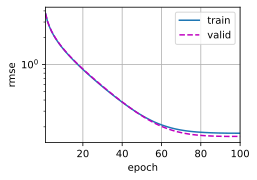

In [30]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, ' f'avg valid log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.394559, valid log rmse 0.240200
fold 2, train log rmse 0.241976, valid log rmse 0.355397
fold 3, train log rmse 0.250525, valid log rmse 0.264123
fold 4, train log rmse 0.394502, valid log rmse 0.212850
fold 5, train log rmse 0.273696, valid log rmse 0.251325
5-fold validation: avg train log rmse: 0.311051, avg valid log rmse: 0.264779


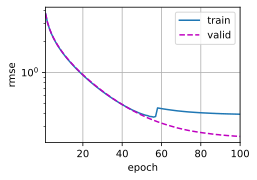

In [31]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 10, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, ' f'avg valid log rmse: {float(valid_l):f}')

fold 1, train log rmse 0.252136, valid log rmse 0.220349
fold 2, train log rmse 0.223961, valid log rmse 0.283651
fold 3, train log rmse 0.231050, valid log rmse 0.247332
fold 4, train log rmse 0.266168, valid log rmse 0.195524
fold 5, train log rmse 0.239268, valid log rmse 0.233033
5-fold validation: avg train log rmse: 0.242517, avg valid log rmse: 0.235978


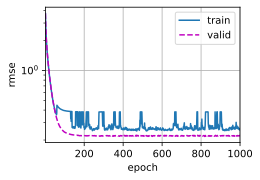

In [32]:
k, num_epochs, lr, weight_decay, batch_size = 5, 1000, 5, 10, 64               # Overfitting
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, ' f'avg valid log rmse: {float(valid_l):f}')

#### Save

In [33]:
def train_and_pred(train_features, test_feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)